
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.25
MAZE = "MiyazakiA-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#BEACS Set Up
DO_GA = False
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 1
BETA_ALP = 0.05

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ □ ■ ■ ■
■ □ ■ □ □ □ A ■
■ ■ ■ ■ ■ ■ $ ■
■ □ □ □ ■ □ □ ■
■ □ ■ ■ ■ ■ □ ■
■ □ □ □ □ □ □ ■
■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 54min 51s, sys: 5.57 s, total: 54min 57s
Wall time: 55min 23s


### Performance

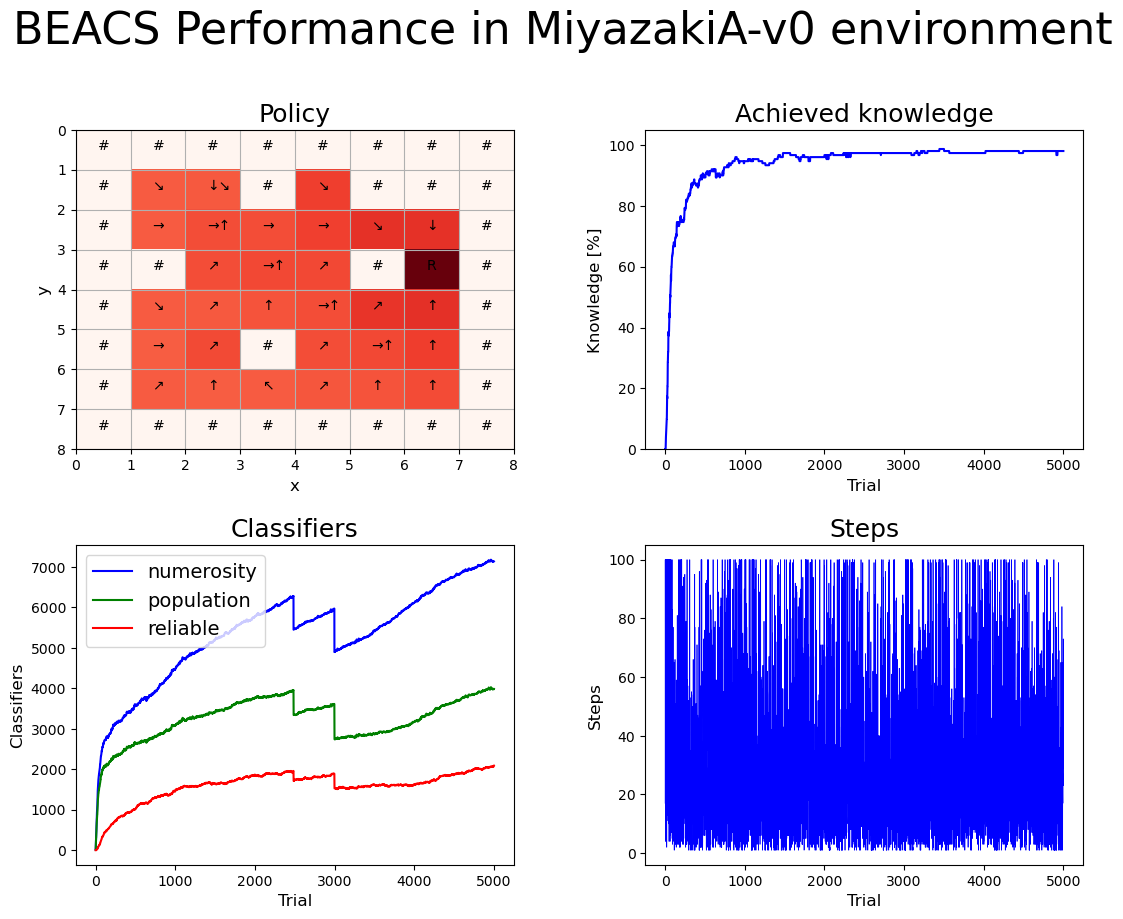

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

agent_explore.zip_population()
population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  1416  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 98.0, 'population': 3986, 'numerosity': 7132, 'reliable': 2088}
Mean reliable population specifity is  0.9675526819923371
Accumulated Error on PEP Probabilities : 6.216441071332715 %

{'knowledge': 98.0, 'population': 1121, 'numerosity': 3496, 'reliable': 497}
Mean reliable population specifity is  0.9413983903420523
Accumulated Error on PEP Probabilities : 6.139213942033905 %


In [7]:
population_explore.sort(key=lambda cl: -cl.q)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

00011111 1 None (#1####00:#16, ##100000:#484, ########:#94, ###00###:#20) (empty)
q: 1.0    ra: 789.7  rb: 797.5  ir: 0.0    f: 797.5  err: 26.78 
exp: 572   num: 19 ee: False PAI_state: 
tga: 150370 tbseq: 151606 talp: 150370 tav: 307.0  



10#11100 2 None (01######:#4, ########:#27, 0######1:#127, 0##0001#:#4) (empty)
q: 1.0    ra: 661.6  rb: 625.8  ir: 0.0    f: 661.6  err: 197.4 
exp: 112   num: 20 ee: False PAI_state: 
tga: 149228 tbseq: 151747 talp: 149228 tav: 2.095e+03 



01010001 2 None (1##91##0:#1256, #010###0:#59, #0#0###0:#49, 10#0###0:#47, 1#10##1#:#37, ########:#123) (empty)
q: 1.0    ra: 901.6  rb: 907.1  ir: 0.0    f: 907.1  err: 33.63 
exp: 1380  num: 20 ee: False PAI_state: 
tga: 151767 tbseq: 151760 talp: 151784 tav: 104.7  



9111##01 5 None (0000###0:#213, ########:#26, 0######0:#6, 0#####10:#5, 1900###0:#9) (empty)
q: 1.0    ra: 835.6  rb: 840.9  ir: 14.77  f: 840.9  err: 27.21 
exp: 175   num: 20 ee: False PAI_state: 
tga: 151316 tbseq: 151130 talp: 151316 ta

00011111 1 [3] (1#####00:#1) (00011111)
q: 0.778  ra: 503.5  rb: 389.4  ir: 0.0    f: 302.9  err: 380.8 
exp: 37    num: 1 ee: True PAI_state: 00100000
tga: 150252 tbseq: 81564 talp: 150252 tav: 2.046e+03 



1900#0#0 7 [3] (########:#6, 0111####:#1, #0######:#1) (empty)
q: 0.7777 ra: 472.7  rb: 393.7  ir: 0.0    f: 306.2  err: 22.06 
exp: 1     num: 1 ee: False PAI_state: 00100000
tga: 151511 tbseq: 151511 talp: 151511 tav: 0.0    



10000000 3 [7] (0###1###:#1) (10000000)
q: 0.7761 ra: 511.6  rb: 617.6  ir: 0.0    f: 397.0  err: 46.19 
exp: 4     num: 1 ee: False PAI_state: 00100000
tga: 151796 tbseq: 148643 talp: 151796 tav: 863.8  



111#0001 4 [2] (#00####0:#1) (11100001)
q: 0.7743 ra: 143.4  rb: 212.3  ir: 0.0    f: 111.0  err: 282.2 
exp: 11    num: 1 ee: True PAI_state: 01000100
tga: 151397 tbseq: 138920 talp: 151397 tav: 1.134e+03 



100111#0 5 None (0######1:#1) (10011100)
q: 0.7737 ra: 669.6  rb: 682.6  ir: 0.0    f: 528.2  err: 18.8  
exp: 5     num: 1 ee: False PAI_stat




00001000 0 [5] (1###0111:#1) (00001000)
q: 0.6211 ra: 497.8  rb: 298.9  ir: 0.0    f: 185.6  err: 100.2 
exp: 6     num: 2 ee: False PAI_state: 00000000
tga: 151415 tbseq: 145491 talp: 151415 tav: 1.294e+03 



9111##01 5 [6] (0000##10:#1) (91110001)
q: 0.6201 ra: 641.3  rb: 523.7  ir: 125.4  f: 324.8  err: 384.8 
exp: 47    num: 4 ee: True PAI_state: 00000000
tga: 151561 tbseq: 104795 talp: 151561 tav: 1.083e+03 



00#11101 0 [3] (###000#0:#1) (empty)
q: 0.6199 ra: 544.4  rb: 550.1  ir: 0.0    f: 337.5  err: 15.49 
exp: 1     num: 1 ee: False PAI_state: 00000010
tga: 150959 tbseq: 150959 talp: 150959 tav: 814.4  



01111100 7 [2] (190000##:#1) (01111100)
q: 0.6181 ra: 659.1  rb: 566.7  ir: 0.0    f: 350.3  err: 105.8 
exp: 9     num: 1 ee: False PAI_state: 00000000
tga: 150722 tbseq: 147147 talp: 150722 tav: 459.5  



##011111 1 None (##100000:#1) (00011111)
q: 0.6175 ra: 217.9  rb: 209.5  ir: 0.0    f: 134.6  err: 274.7 
exp: 10    num: 1 ee: True PAI_state: 
tga: 150370 tbseq:




00011100 0 [3] (911#00#1:#1) (00011100)
q: 0.218  ra: 244.5  rb: 359.0  ir: 0.0    f: 53.3   err: 388.2 
exp: 19    num: 1 ee: False PAI_state: 00000000
tga: 151990 tbseq: 134396 talp: 151990 tav: 926.0  



1900#000 1 [3] (011111##:#1) (19000000)
q: 0.2163 ra: 486.7  rb: 420.9  ir: 512.7  f: 91.07  err: 497.0 
exp: 26    num: 1 ee: False PAI_state: 00000000
tga: 150149 tbseq: 104005 talp: 150149 tav: 1.808e+03 



00000111 2 [7] (#####000:#1) (00000111)
q: 0.2102 ra: 479.9  rb: 198.6  ir: 0.0    f: 41.75  err: 206.8 
exp: 14    num: 1 ee: False PAI_state: 00100000
tga: 148760 tbseq: 122557 talp: 148760 tav: 1.993e+03 



10011100 7 [7] (01######:#1) (10011100)
q: 0.2091 ra: 643.4  rb: 644.5  ir: 0.0    f: 134.5  err: 90.87 
exp: 18    num: 1 ee: False PAI_state: 00100000
tga: 151981 tbseq: 139848 talp: 151995 tav: 706.1  



00000000 4 [2] (#1#1###1:#1) (00000000)
q: 0.2091 ra: 619.9  rb: 561.3  ir: 0.0    f: 117.3  err: 172.2 
exp: 18    num: 1 ee: False PAI_state: 00000010
tga: 1

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '1', '0'),
 ('0', '1', '0', '0', '0', '1', '0', '0'),
 ('0', '0', '1', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '0', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 59.6 s, sys: 340 ms, total: 59.9 s
Wall time: 1min 1s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 57.2 s, sys: 203 ms, total: 57.4 s
Wall time: 58.2 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 58 s, sys: 235 ms, total: 58.2 s
Wall time: 59.1 s


### Performance

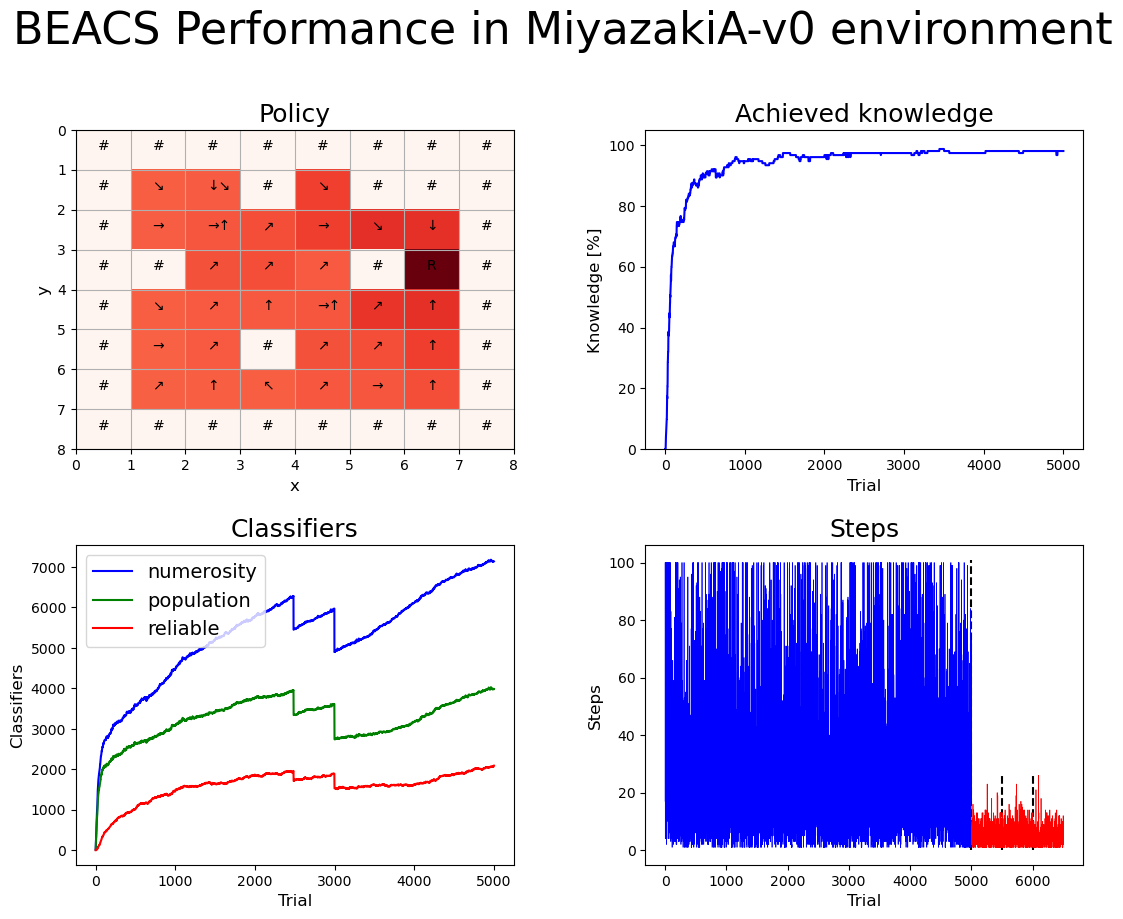

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  30.408  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  5.358  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.346  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.936  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 98.0, 'population': 1121, 'numerosity': 3496, 'reliable': 497}
{'knowledge': 98.0, 'population': 1121, 'numerosity': 3496, 'reliable': 497}
{'knowledge': 98.0, 'population': 1121, 'numerosity': 3496, 'reliable': 497}
{'knowledge': 98.0, 'population': 1121, 'numerosity': 3496, 'reliable': 497}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if (not cl.behavioral_sequence)]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

389


11091000 3 None (0#110#1#:#1088, ########:#130, ##100#11:#41, ##1191#1:#49, 00100###:#33, 0##10##1:#29) (empty)
q: 1.0    ra: 973.9  rb: 992.7  ir: 806.8  f: 992.7  err: 28.54 
exp: 1158  num: 20 ee: False PAI_state: 
tga: 152016 tbseq: 151764 talp: 152016 tav: 77.5   



11119101 4 None (0###0010:#319, ##0910#0:#20, ########:#79) (empty)
q: 1.0    ra: 988.6  rb: 977.3  ir: 764.1  f: 988.6  err: 24.61 
exp: 396   num: 20 ee: False PAI_state: 
tga: 151924 tbseq: 151037 talp: 151925 tav: 199.7  



91110001 0 None (0#####10:#1078, 0######0:#45, ########:#145, 1900###0:#39, 0000###0:#23) (empty)
q: 1.0    ra: 987.0  rb: 979.6  ir: 822.5  f: 987.0  err: 25.96 
exp: 1000  num: 20 ee: False PAI_state: 
tga: 151914 tbseq: 151130 talp: 151914 tav: 116.9  



1900#000 1 None (0111##1#:#1064, 001#####:#35, 00####1#:#46, 0111####:#33, ########:#31, 00######:#22, 9111###1:#19, 01###1##:#23) (empty)
q: 1.0    ra: 963.0  rb: 960.1  ir: 763.5  f: 963.0  err: 59.51 
exp: 583   num: 20 ee: False 